# Ariel Data Challenge 2024: Introductory model: training


In [1]:
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats
from tqdm import tqdm
import pickle

from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error

# A look at the data

We start by reading the metadata:

In [2]:
train_adc_info = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/train_adc_info.csv',
                           index_col='planet_id')
train_labels = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/train_labels.csv',
                           index_col='planet_id')
wavelengths = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/wavelengths.csv')
axis_info = pd.read_parquet('/kaggle/input/ariel-data-challenge-2024/axis_info.parquet')


Some facts about the data:
- We have 673 planets for training. These planets belong to two different stars.
- There will be roughly 800 planets for testing (but the test data is hidden).
- The competition is a multi-output regression task with 283 targets to predict.

## The FGS1 data

Having read the metadata, we'll tackle the FGS1 data (Fine Guidance System). The FGS1 measurements consist of one file per planet (673 files for 673 planets for training). For now, we ignore the calibration files.

Each file contains 135,000 rows of images taken at 0.1 second time steps. Each row is a 32\*32 image at a single wavelength.

We read a sample file:

In [3]:
planet_id = 14485303
f_signal = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/train/{planet_id}/FGS1_signal.parquet')
f_signal

,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,...,column_1014,column_1015,column_1016,column_1017,column_1018,column_1019,column_1020,column_1021,column_1022,column_1023
0,315,313,308,301,311,315,307,298,315,320,...,304,317,304,284,321,312,314,340,297,310
1,286,325,303,309,307,332,300,299,334,319,...,306,315,304,302,312,327,318,270,299,302
2,304,292,303,318,313,308,300,316,335,356,...,329,330,305,314,302,291,314,323,315,310
3,312,300,299,347,300,317,320,319,333,350,...,316,313,310,294,319,298,310,291,287,319
4,324,313,300,334,326,312,319,305,341,317,...,294,300,313,326,334,316,293,322,310,305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134995,317,318,312,306,309,321,317,316,316,330,...,332,319,310,312,309,327,293,334,333,317
134996,312,333,321,337,311,292,315,332,315,321,...,338,298,312,317,298,304,296,280,308,297
134997,316,311,312,303,290,304,301,319,321,338,...,301,324,298,330,314,328,295,332,308,317
134998,302,309,313,306,323,315,307,320,304,340,...,308,299,324,308,321,294,312,329,315,304


Every row of the file corresponds to an image of a star. The images come in pairs, and the second image is lighter than the first one:

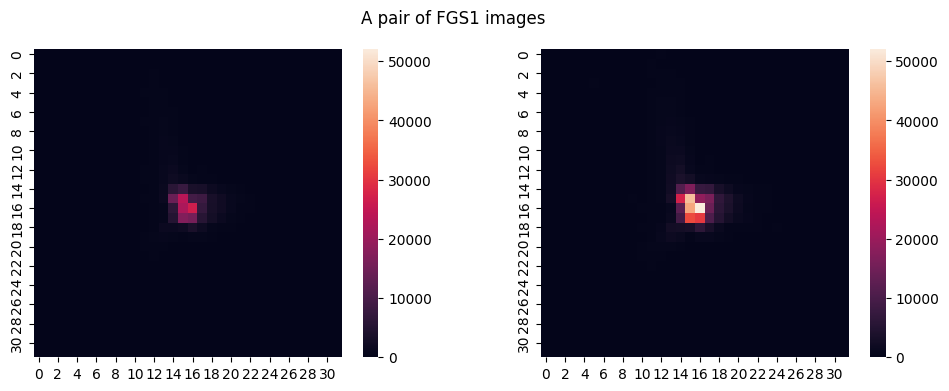

In [4]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(f_signal.iloc[0].values.reshape(32, 32), ax=ax1, vmin=0, vmax=52000)
ax1.set_aspect('equal')
sns.heatmap(f_signal.iloc[1].values.reshape(32, 32), ax=ax2, vmin=0, vmax=52000)
ax2.set_aspect('equal')
plt.suptitle('A pair of FGS1 images')
plt.show()

To see the time series, we first have to compute the difference between the even and the odd frames to get the net signal (67500 time steps). We then take the mean over all 1024 pixels. The net signal is very noisy, and we smoothen it by computing a moving average. The plot of the smoothened signal clearly shows that the signal intensity is reduced (i.e., the image gets darker) while the planet passes in front of the star (between time steps 23500 and 44000).

The left diagram shows a planet with a strong reduction of the signal intensity, the right diagram shows a planet with a weak reduction:

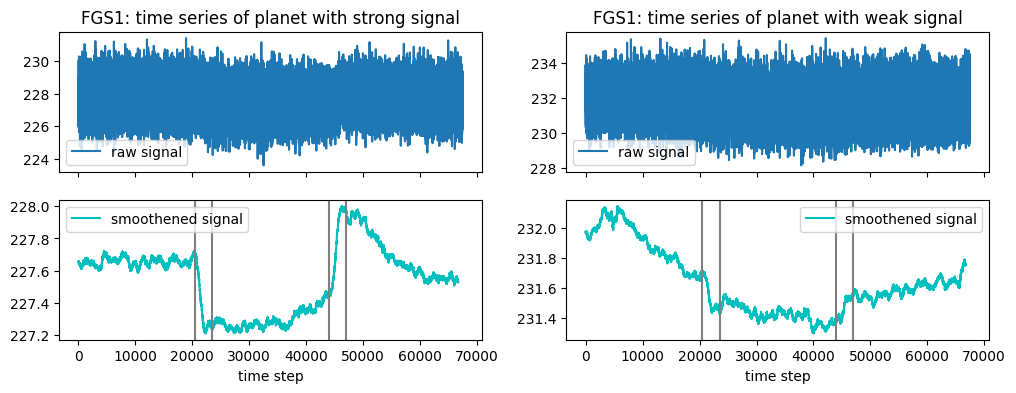

In [5]:
_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, figsize=(12, 4))

planet_id = 14485303
f_signal = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/train/{planet_id}/FGS1_signal.parquet')

mean_signal = f_signal.values.mean(axis=1)
net_signal = mean_signal[1::2] - mean_signal[0::2]
cum_signal = net_signal.cumsum()
window=800
smooth_signal = (cum_signal[window:] - cum_signal[:-window]) / window

ax1.set_title('FGS1: time series of planet with strong signal')
ax1.plot(net_signal, label='raw signal')
ax1.legend()
ax3.plot(smooth_signal, color='c', label='smoothened signal')
ax3.legend()
ax3.set_xlabel('time step')
for time_step in [20500, 23500, 44000, 47000]:
    ax3.axvline(time_step, color='gray')

planet_id = 4249337798
f_signal = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/train/{planet_id}/FGS1_signal.parquet')

mean_signal = f_signal.values.mean(axis=1)
net_signal = mean_signal[1::2] - mean_signal[0::2]
cum_signal = net_signal.cumsum()
window=800
smooth_signal = (cum_signal[window:] - cum_signal[:-window]) / window

ax2.set_title('FGS1: time series of planet with weak signal')
ax2.plot(net_signal, label='raw signal')
ax2.legend()
ax4.plot(smooth_signal, color='c', label='smoothened signal')
ax4.legend()
ax4.set_xlabel('time step')
for time_step in [20500, 23500, 44000, 47000]:
    ax4.axvline(time_step, color='gray')

# plt.suptitle('FGS1 time series', y=0.96)
plt.show()

## The AIRS data

AIRS is the other sensor of the satellite. It produces one file per planet as well. Each file contains 11,250 rows of images captured at constant time steps. Each 32 x 356 image has been flattened into 11392 columns.

In [6]:
planet_id = 4249337798
a_signal = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/train/{planet_id}/AIRS-CH0_signal.parquet')
a_signal

,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,...,column_11382,column_11383,column_11384,column_11385,column_11386,column_11387,column_11388,column_11389,column_11390,column_11391
0,840,833,820,836,821,845,824,830,828,825,...,825,811,840,820,833,806,808,831,824,826
1,824,818,826,818,843,833,827,806,819,846,...,807,824,822,815,829,827,817,828,810,816
2,824,818,814,823,824,842,836,820,815,818,...,857,806,800,798,848,817,820,825,819,822
3,826,834,821,812,819,837,811,833,822,816,...,840,816,798,825,820,827,811,818,842,830
4,826,817,788,848,831,804,819,854,823,826,...,831,810,820,799,828,860,815,815,818,791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11245,816,815,811,812,802,801,825,814,825,831,...,830,809,807,826,816,813,799,841,827,816
11246,817,834,830,813,829,822,798,828,811,844,...,829,825,812,820,808,809,819,813,834,810
11247,821,852,817,813,810,801,830,819,836,826,...,807,837,808,822,846,796,833,818,816,820
11248,820,826,811,803,815,809,809,810,823,827,...,821,845,839,827,804,819,810,813,813,802


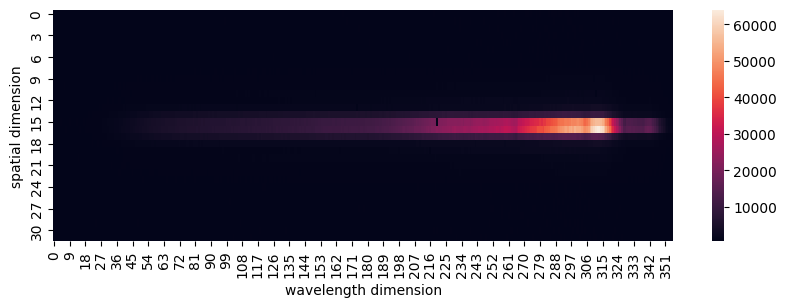

In [7]:
a_signal = a_signal.values.reshape(11250, 32, 356)

plt.figure(figsize=(10, 3))
sns.heatmap(a_signal[1])
plt.ylabel('spatial dimension')
plt.xlabel('wavelength dimension')
plt.show()

The data again is a time series, and we can see how the star is obscured while the planet is passing in front of it.

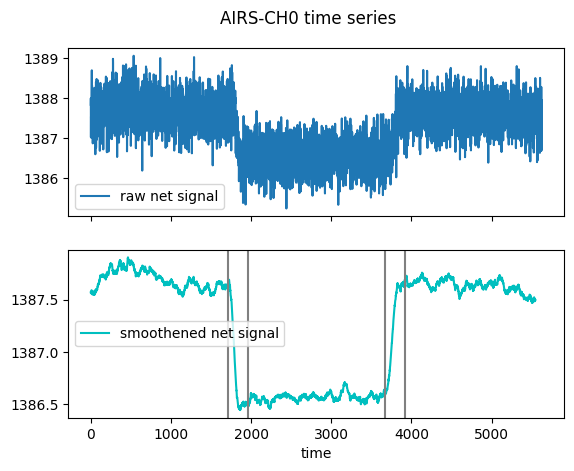

In [8]:
mean_signal = a_signal.mean(axis=2).mean(axis=1)
net_signal = mean_signal[1::2] - mean_signal[0::2]
cum_signal = net_signal.cumsum()
window=80
smooth_signal = (cum_signal[window:] - cum_signal[:-window]) / window

_, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(net_signal, label='raw net signal')
ax1.legend()
ax2.plot(smooth_signal, color='c', label='smoothened net signal')
ax2.legend()
ax2.set_xlabel('time')
for time_step in [20500, 23500, 44000, 47000]:
    ax2.axvline(time_step * 11250 // 135000, color='gray')
plt.suptitle('AIRS-CH0 time series', y=0.96)
plt.show()


# Reading the data

We now read the FGS1 data and the AIRS-CH0 data for all 673 training planets. As the dataset doesn't fit into RAM completely, we keep only two one-dimensional time series for every planet. At the end we'll have
1. A time series with 67500 steps per planet taken from the FGS1 data, and
2. A time series with 5625 steps per planet taken from the AIRS-CH0 data.

We use the Jupyter `%%writefile` cell magic to save the function code to a file. This ensures that the inference notebook will process the test data in exactly the same way as this notebook processes the training data.

In [9]:
%%writefile f_read_and_preprocess.py

def f_read_and_preprocess(dataset, adc_info, planet_ids):
    """Read the FGS1 files for all planet_ids and extract the time series.
    
    Parameters
    dataset: 'train' or 'test'
    adc_info: metadata dataframe, either train_adc_info or test_adc_info
    planet_ids: list of planet ids
    
    Returns
    dataframe with one row per planet_id and 67500 values per row
    
    """
    f_raw_train = np.full((len(planet_ids), 67500), np.nan, dtype=np.float32)
    for i, planet_id in tqdm(list(enumerate(planet_ids))):
        f_signal = pl.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/{planet_id}/FGS1_signal.parquet')
        mean_signal = f_signal.cast(pl.Int32).sum_horizontal().cast(pl.Float32).to_numpy() / 1024 # mean over the 32*32 pixels
        net_signal = mean_signal[1::2] - mean_signal[0::2]
        f_raw_train[i] = net_signal
    return f_raw_train
    

Writing f_read_and_preprocess.py


In [10]:
%%time
exec(open('f_read_and_preprocess.py', 'r').read())
f_raw_train = f_read_and_preprocess('train', train_adc_info, train_labels.index)
with open('f_raw_train.pickle', 'wb') as f:
    pickle.dump(f_raw_train, f)


100%|██████████| 673/673 [08:46<00:00,  1.28it/s]


CPU times: user 18min 28s, sys: 2min 4s, total: 20min 33s
Wall time: 8min 46s


In [11]:
%%writefile a_read_and_preprocess.py
def a_read_and_preprocess(dataset, adc_info, planet_ids):
    """Read the AIRS-CH0 files for all planet_ids and extract the time series.
    
    Parameters
    dataset: 'train' or 'test'
    adc_info: metadata dataframe, either train_adc_info or test_adc_info
    planet_ids: list of planet ids
    
    Returns
    dataframe with one row per planet_id and 5625 values per row
    
    """
    a_raw_train = np.full((len(planet_ids), 5625), np.nan, dtype=np.float32)
    for i, planet_id in tqdm(list(enumerate(planet_ids))):
        signal = pl.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/{planet_id}/AIRS-CH0_signal.parquet')
        mean_signal = signal.cast(pl.Int32).sum_horizontal().cast(pl.Float32).to_numpy() / (32*356) # mean over the 32*356 pixels
        net_signal = mean_signal[1::2] - mean_signal[0::2]
        a_raw_train[i] = net_signal
    return a_raw_train
    

Writing a_read_and_preprocess.py


In [12]:
%%time
exec(open('a_read_and_preprocess.py', 'r').read())
a_raw_train = a_read_and_preprocess('train', train_adc_info, train_labels.index)
with open('a_raw_train.pickle', 'wb') as f:
    pickle.dump(a_raw_train, f)


100%|██████████| 673/673 [13:25<00:00,  1.20s/it]

CPU times: user 36min 57s, sys: 1min 48s, total: 38min 46s
Wall time: 13min 26s


As a plausibility check, we plot the means of all time series:

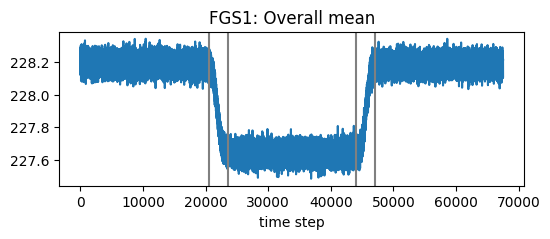

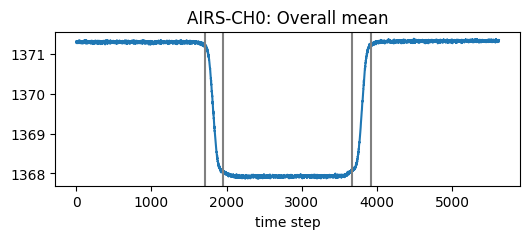

In [13]:
plt.figure(figsize=(6, 2))
plt.plot(f_raw_train.mean(axis=0))
for time_step in [20500, 23500, 44000, 47000]:
    plt.axvline(time_step, color='gray')
plt.xlabel('time step')
plt.title('FGS1: Overall mean')
plt.show()

plt.figure(figsize=(6, 2))
plt.plot(a_raw_train.mean(axis=0))
for time_step in [20500, 23500, 44000, 47000]:
    plt.axvline(time_step * 11250 // 135000, color='gray')
plt.xlabel('time step')
plt.title('AIRS-CH0: Overall mean')
plt.show()

# Feature engineering

We want to know how much darker the images get when the planet obscures the star. The time series diagrams above show that the planets reduce the brightness of the stars (on average) by 0.2 % (from 228.2 to 227.6 or from 1371 to 1368).

In [14]:
%%writefile feature_engineering.py

def feature_engineering(f_raw, a_raw):
    """Create a dataframe with two features from the raw data.
    
    Parameters:
    f_raw: ndarray of shape (n_planets, 67500)
    a_raw: ndarray of shape (n_planets, 5625)
    
    Return value:
    df: DataFrame of shape (n_planets, 2)
    """
    obscured = f_raw[:, 23500:44000].mean(axis=1)
    unobscured = (f_raw[:, :20500].mean(axis=1) + f_raw[:, 47000:].mean(axis=1)) / 2
    f_relative_reduction = (unobscured - obscured) / unobscured
    obscured = a_raw[:, 1958:3666].mean(axis=1)
    unobscured = (a_raw[:, :1708].mean(axis=1) + a_raw[:, 3916:].mean(axis=1)) / 2
    a_relative_reduction = (unobscured - obscured) / unobscured

    df = pd.DataFrame({'a_relative_reduction': a_relative_reduction,
                       'f_relative_reduction': f_relative_reduction})
    
    return df


Writing feature_engineering.py


In [15]:
exec(open('feature_engineering.py', 'r').read())

train = feature_engineering(f_raw_train, a_raw_train)

The following scatterplot shows a strong correlation between the signal reduction when the planet is in front of the star and one of the targets we want to predict. The other targets have a similarly high correlation.

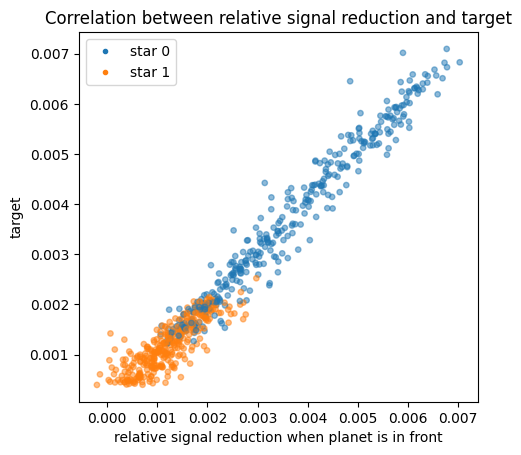

In [16]:

color_array = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])
plt.scatter(train.a_relative_reduction, train_labels.wl_1, s=15, alpha=0.5,
            c=color_array[train_adc_info.star])
plt.xlabel('relative signal reduction when planet is in front')
plt.ylabel('target')
plt.title('Correlation between relative signal reduction and target')
plt.gca().set_aspect('equal')
points = [plt.Line2D([0], [0], label=f'star {i}', marker='o', markersize=3,
         markeredgecolor=color_array[i], markerfacecolor=color_array[i], linestyle='') for i in range(2)]

plt.legend(handles=points)
plt.show()

# The model and the cross-validation

To keep things simple, we predict the targets with ridge regression.

We are interested in three cross-validation metrics:
1. The R2 score is above 0.9, which confirms the correlation we've seen in the scatterplot.
2. The root mean squared error will be the predicted uncertainty.
3. The competition metric gives an indication of the leaderboard score. Unfortunately the competition metric depends on the value of `sigma_true`, which I don't know.

In [17]:
model = Ridge(alpha=1e-12)

oof_pred = cross_val_predict(model, train, train_labels)

print(f"# R2 score: {r2_score(train_labels, oof_pred):.3f}")
sigma_pred = mean_squared_error(train_labels, oof_pred, squared=False)
print(f"# Root mean squared error: {sigma_pred:.6f}")

# R2 score: 0.971
# Root mean squared error: 0.000293


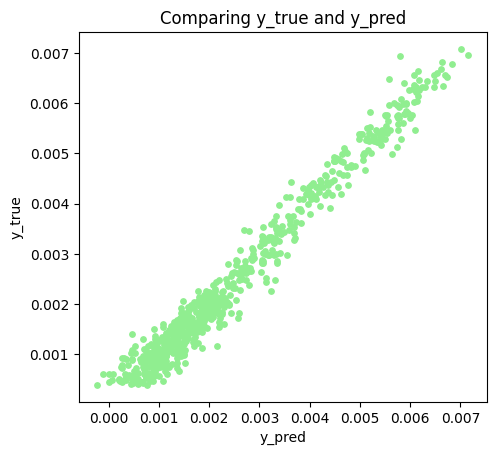

In [18]:
col = 1
plt.scatter(oof_pred[:,col], train_labels.iloc[:,col], s=15, c='lightgreen')
plt.gca().set_aspect('equal')
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.title('Comparing y_true and y_pred')
plt.show()

In [19]:
%%writefile competition_score.py
# Adapted from https://www.kaggle.com/code/metric/ariel-gaussian-log-likelihood
class ParticipantVisibleError(Exception):
    pass

def competition_score(
        solution: pd.DataFrame,
        submission: pd.DataFrame,
        naive_mean: float,
        naive_sigma: float,
        sigma_true: float,
        row_id_column_name='planet_id',
    ) -> float:
    '''
    This is a Gaussian Log Likelihood based metric. For a submission, which contains the predicted mean (x_hat) and variance (x_hat_std),
    we calculate the Gaussian Log-likelihood (GLL) value to the provided ground truth (x). We treat each pair of x_hat,
    x_hat_std as a 1D gaussian, meaning there will be 283 1D gaussian distributions, hence 283 values for each test spectrum,
    the GLL value for one spectrum is the sum of all of them.

    Inputs:
        - solution: Ground Truth spectra (from test set)
            - shape: (nsamples, n_wavelengths)
        - submission: Predicted spectra and errors (from participants)
            - shape: (nsamples, n_wavelengths*2)
        naive_mean: (float) mean from the train set.
        naive_sigma: (float) standard deviation from the train set.
        sigma_true: (float) essentially sets the scale of the outputs.
    '''

    del solution[row_id_column_name]
    del submission[row_id_column_name]

    if submission.min().min() < 0:
        raise ParticipantVisibleError('Negative values in the submission')
    for col in submission.columns:
        if not pd.api.types.is_numeric_dtype(submission[col]):
            raise ParticipantVisibleError(f'Submission column {col} must be a number')

    n_wavelengths = len(solution.columns)
    if len(submission.columns) != n_wavelengths*2:
        raise ParticipantVisibleError('Wrong number of columns in the submission')

    y_pred = submission.iloc[:, :n_wavelengths].values
    # Set a non-zero minimum sigma pred to prevent division by zero errors.
    sigma_pred = np.clip(submission.iloc[:, n_wavelengths:].values, a_min=10**-15, a_max=None)
    y_true = solution.values

    GLL_pred = np.sum(scipy.stats.norm.logpdf(y_true, loc=y_pred, scale=sigma_pred))
    GLL_true = np.sum(scipy.stats.norm.logpdf(y_true, loc=y_true, scale=sigma_true * np.ones_like(y_true)))
    GLL_mean = np.sum(scipy.stats.norm.logpdf(y_true, loc=naive_mean * np.ones_like(y_true), scale=naive_sigma * np.ones_like(y_true)))

    submit_score = (GLL_pred - GLL_mean)/(GLL_true - GLL_mean)
    return float(np.clip(submit_score, 0.0, 1.0))

Writing competition_score.py


In [20]:
%%writefile postprocessing.py

def postprocessing(pred_array, index, sigma_pred):
    """Create a submission dataframe from its components
    
    Parameters:
    pred_array: ndarray of shape (n_samples, 283)
    index: pandas.Index of length n_samples with name 'planet_id'
    sigma_pred: float
    
    Return value:
    df: DataFrame of shape (n_samples, 566) with planet_id as index
    """
    return pd.concat([pd.DataFrame(pred_array.clip(0, None), index=index, columns=wavelengths.columns),
                      pd.DataFrame(sigma_pred, index=index, columns=[f"sigma_{i}" for i in range(1, 284)])],
                     axis=1)



Writing postprocessing.py


In [21]:
exec(open('competition_score.py', 'r').read())
exec(open('postprocessing.py', 'r').read())

oof_df = postprocessing(oof_pred, train_adc_info.index, sigma_pred)
display(oof_df)

gll_score = competition_score(train_labels.copy().reset_index(),
                              oof_df.copy().reset_index(),
                              naive_mean=train_labels.values.mean(),
                              naive_sigma=train_labels.values.std(),
                              sigma_true=0.000003)
print(f"# Estimated competition score: {gll_score:.3f}")
# Estimated competition score: 0.259

,wl_1,wl_2,wl_3,wl_4,wl_5,wl_6,wl_7,wl_8,wl_9,wl_10,...,sigma_274,sigma_275,sigma_276,sigma_277,sigma_278,sigma_279,sigma_280,sigma_281,sigma_282,sigma_283
planet_id,,,,,,,,,,,,,,,,,,,,,
785834,0.001814,0.001849,0.001843,0.001839,0.001840,0.001832,0.001832,0.001844,0.001841,0.001837,...,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293
14485303,0.001926,0.001958,0.001952,0.001948,0.001950,0.001942,0.001942,0.001951,0.001948,0.001945,...,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293
17002355,0.003049,0.003076,0.003070,0.003065,0.003067,0.003059,0.003058,0.003067,0.003064,0.003059,...,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293
24135240,0.001323,0.001356,0.001351,0.001347,0.001349,0.001342,0.001342,0.001351,0.001349,0.001345,...,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293
25070640,0.002137,0.002168,0.002162,0.002158,0.002160,0.002152,0.002151,0.002161,0.002158,0.002154,...,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4249337798,0.000983,0.001008,0.001006,0.001002,0.001007,0.001002,0.001000,0.001004,0.001001,0.001000,...,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293
4257395405,0.003848,0.003875,0.003868,0.003864,0.003865,0.003856,0.003856,0.003866,0.003863,0.003858,...,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293
4266129805,0.006656,0.006684,0.006674,0.006669,0.006666,0.006654,0.006655,0.006670,0.006667,0.006660,...,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293


# Estimated competition score: 0.259


# Refitting and saving the model

In [22]:
# Refit the model to the full dataset
model.fit(train, train_labels)
with open('model.pickle', 'wb') as f:
    pickle.dump(model, f)
with open('sigma_pred.pickle', 'wb') as f:
    pickle.dump(sigma_pred, f)


# Submission

In [23]:
# Load the data
test_adc_info = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/test_adc_info.csv',
                           index_col='planet_id')
sample_submission = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/sample_submission.csv',
                                index_col='planet_id')
f_raw_test = f_read_and_preprocess('test', test_adc_info, sample_submission.index)
a_raw_test = a_read_and_preprocess('test', test_adc_info, sample_submission.index)
test = feature_engineering(f_raw_test, a_raw_test)

# Load the model
with open('model.pickle', 'rb') as f:
    model = pickle.load(f)
with open('sigma_pred.pickle', 'rb') as f:
    sigma_pred = pickle.load(f)

# Predict
test_pred = model.predict(test)

# Package into submission file
sub_df = postprocessing(test_pred, sample_submission.index, sigma_pred)
display(sub_df)
sub_df.to_csv('submission.csv')
#!head submission.csv

100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


,wl_1,wl_2,wl_3,wl_4,wl_5,wl_6,wl_7,wl_8,wl_9,wl_10,...,sigma_274,sigma_275,sigma_276,sigma_277,sigma_278,sigma_279,sigma_280,sigma_281,sigma_282,sigma_283
planet_id,,,,,,,,,,,,,,,,,,,,,
499191466,0.002819,0.002847,0.002841,0.002836,0.002839,0.002831,0.00283,0.002838,0.002835,0.002831,...,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293
